# Housing - Lineer Regression

sale_price prediction

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from sklearn.linear_model import LinearRegression

sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)


## Tuning

In [195]:
# tuning params for mappings

building_category_mapping = ['FAMILY', 'APARTMENT', 'LUXURY', 'FACILITIES'] # maps building_class_category

# tuning params for outliers

# order: min, then quantile, then max !
sale_price_min = 1000 # min intuitive sale price, if -1, discarded
sale_price_lq = 0.01  # left quantile
sale_price_rq = 0.99  # right quantile
sale_price_max = -1   

#order: min, then quantile, then max
total_units_min = 0    # if -1, discarded
total_units_max = 10   # if -1, discarded
total_units_lq = 0.01
total_units_rq = 0.99

# order: min, then quantile, then max
gross_square_feet_min = -1     # if -1, discarded
gross_square_feet_max = -1     # if -1, discarded
gross_square_feet_lq = 0.05
gross_square_feet_rq = 0.99

land_square_feet_min = -1     # if -1, discarded
land_square_feet_max = -1     # if -1, discarded
land_square_feet_lq = 0.01
land_square_feet_rq = 0.99

# for categorial
neighborhood_min_len = 2  # minimum meaningful length
year_built_min = 1900


In [196]:
# read all datasets w/ dates

filenames = glob.glob(os.path.join('dataset/housing/', 'r*.csv'))

#
li = []

for filename in filenames:
    df = pd.read_csv(filename, \
                dtype={'YEAR BUILT': object, 'BLOCK': object, 'LOT': object, 'ZIP CODE': object, 
                       'COMMERCIAL UNITS': object,
                       'BOROUGH': object, 'NEIGHBORHOOD': object, 'BUILDING CLASS CATEGORY': object,
                       'TAX CLASS AT PRESENT': object,  'EASE-MENT': object,
                       'BUILDING CLASS AT PRESENT': object, 'ADDRESS': object, 
                       'APART\nMENT\nNUMBER': object,
                       'RESIDENTIAL UNITS': object, 'COMMERCIAL UNITS': object, 'TOTAL UNITS': object,
                       'LAND SQUARE FEET': object, 'GROSS SQUARE FEET': object,
                       'TAX CLASS AT TIME OF SALE': object, 'BUILDING CLASS AT TIME OF SALE': object,
                       'SALE\nPRICE': str}, \
                parse_dates=['SALE DATE'], \
                infer_datetime_format=True)
    li.append(df)


raw_data = pd.concat(li, axis=0, ignore_index=True)


raw_data.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APART MENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09


# EDA stage

## Preperations
Apply all gains from _EDA stage

In [197]:
# change columns' order and names

data = raw_data.copy()

data.columns = ['borough', 'neighborhood', 'building_class_category',
                    'tax_class_at_present', 'block', 'lot', 'easement',
                    'building_class_at_present', 'address', 'apartment_number',
                    'zipcode', 'residential_units', 'commercial_units', 'total_units',
                    'land_square_feet', 'gross_square_feet', 'year_built',
                    'tax_class_at_sale', 'building_class_at_sale',
                    'sale_price', 'sale_date']

data.rename(columns={"building_class_category": "building_category"}, inplace=True)


data.head(1)

,borough,neighborhood,building_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09


In [198]:
# Apply all gains from _EDA stage

data['borough'] = data['borough'].map({'1':'Manhattan', '3':'Brooklyn', '2':'Bronx', '4':'Queens', '5':'Staten Island'})  

data['sale_price'] = data['sale_price'].str.replace(r',|\$', '').astype(float)
data['neighborhood'] = data.neighborhood.str.split(r'(\s+)$', expand=True)[0]

#
data['building_category'] = data['building_category'].str.split(r'(\s+)$', expand=True)[0] \
                                                     .str.split(r'(^\S+)(\s+)', expand=True)[3]

for m in building_category_mapping:
    data.loc[data.building_category.str.contains(m, na=False), 'building_category_map'] = m
    
data.loc[data.building_category_map.isna(), 'building_category_map'] = 'OTHER'

#
data.rename(columns={"tax_class_at_present": "tax_class"}, inplace=True)
data.rename(columns={"tax_class_at_sale": "tax_class_map"}, inplace=True)

data['tax_class'] = data['tax_class'].str.replace(r'\s+', '').astype(object)
data['tax_class_map'] = data['tax_class_map'].str.replace(r'\s+', '').astype(object)

#
data.drop(['lot', 'block', 'easement'], axis=1, inplace=True)

#
data.drop(['building_class_at_present'], axis=1, inplace=True)

data.rename(columns={"building_class_at_sale": "building_class"}, inplace=True)

data['building_class'] = data['building_class'].str.replace(r'[^\S+]', '').astype(object)
data['building_class_map'] = data['building_class'].str[0:1]

#
data.drop(['apartment_number', 'address'], axis=1, inplace=True)

#
for col in ('residential_units', 'commercial_units', 'total_units'):
    data[col] = data[col].str.replace(r',', '').astype(int)


data.loc[(data.commercial_units == 0), 'building_type'] = 'RESIDENTIAL'
data.loc[(data.commercial_units > 0) & (data.residential_units == 0), 'building_type'] = 'COMMERCIAL'
data.loc[(data.commercial_units > 0) & (data.residential_units > 0), 'building_type'] = 'COMMERCIAL W/ RESIDENTIAL'

#
for col in ('land_square_feet', 'gross_square_feet'):
    data[col] = data[col].str.replace(r',', '').astype(int)

#
data['sale_month'] = data.sale_date.dt.month.astype(object)
data['sale_year'] = data.sale_date.dt.year.astype(object)



In [199]:
data.head(2)

,borough,neighborhood,building_category,tax_class,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_map,building_class,sale_price,sale_date,building_category_map,building_class_map,building_type,sale_month,sale_year
0,Brooklyn,,CONDOS - 2-10 UNIT RESIDENTIAL,,11220,0,0,0,0,0,0,2,R1,403572.0,2013-07-09,OTHER,R,RESIDENTIAL,7,2013
1,Brooklyn,,CONDOS - 2-10 UNIT RESIDENTIAL,,11220,0,0,0,0,0,0,2,R1,218010.0,2013-07-12,OTHER,R,RESIDENTIAL,7,2013


In [200]:
# change column order, in a meaningful way


data = data[['borough', 'neighborhood', 
             'building_class', 'building_class_map', 
             'building_category', 'building_category_map', 'building_type', 
             'tax_class', 'tax_class_map', 
             'zipcode',
             'residential_units', 'commercial_units', 'total_units',
             'land_square_feet', 'gross_square_feet', 
             'year_built',
             'sale_date', 'sale_month', 'sale_year',
             'sale_price']]

In [201]:
data.head(1)

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_month,sale_year,sale_price
0,Brooklyn,,R1,R,CONDOS - 2-10 UNIT RESIDENTIAL,OTHER,RESIDENTIAL,,2,11220,0,0,0,0,0,0,2013-07-09,7,2013,403572.0


In [202]:
data.dtypes

borough                          object
neighborhood                     object
building_class                   object
building_class_map               object
building_category                object
building_category_map            object
building_type                    object
tax_class                        object
tax_class_map                    object
zipcode                          object
residential_units                 int64
commercial_units                  int64
total_units                       int64
land_square_feet                  int64
gross_square_feet                 int64
year_built                       object
sale_date                datetime64[ns]
sale_month                       object
sale_year                        object
sale_price                      float64
dtype: object

## Outliers
log transformation w/ 0 values meaningless. so it is better to slice outliers, than transform

In [203]:
data_outliers = data.copy()

In [204]:
data.describe(include='all')

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_month,sale_year,sale_price
count,85975,85975,85975,85975,81771,85975,85975,85975,85975,85975,85975.000000,85975.000000,85975.000000,8.597500e+04,8.597500e+04,85975,85975,85975.0,85975.0,8.597500e+04
unique,5,257,170,24,39,5,3,11,5,185,NaN,NaN,NaN,NaN,NaN,160,386,12.0,2.0,NaN
top,Manhattan,MIDTOWN WEST,D4,R,ONE FAMILY HOMES,APARTMENT,RESIDENTIAL,2,2,10019,NaN,NaN,NaN,NaN,NaN,0,2012-09-27 00:00:00,12.0,2013.0,NaN
freq,27395,6264,13461,24037,14846,35183,77358,32899,38662,6193,NaN,NaN,NaN,NaN,NaN,11782,988,11056.0,47486.0,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-26 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.084397,0.248619,2.390660,3.085275e+03,5.049742e+03,NaN,NaN,NaN,NaN,8.850979e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.581686,5.251332,31.063284,5.501497e+04,2.836546e+04,NaN,NaN,NaN,NaN,9.424213e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00


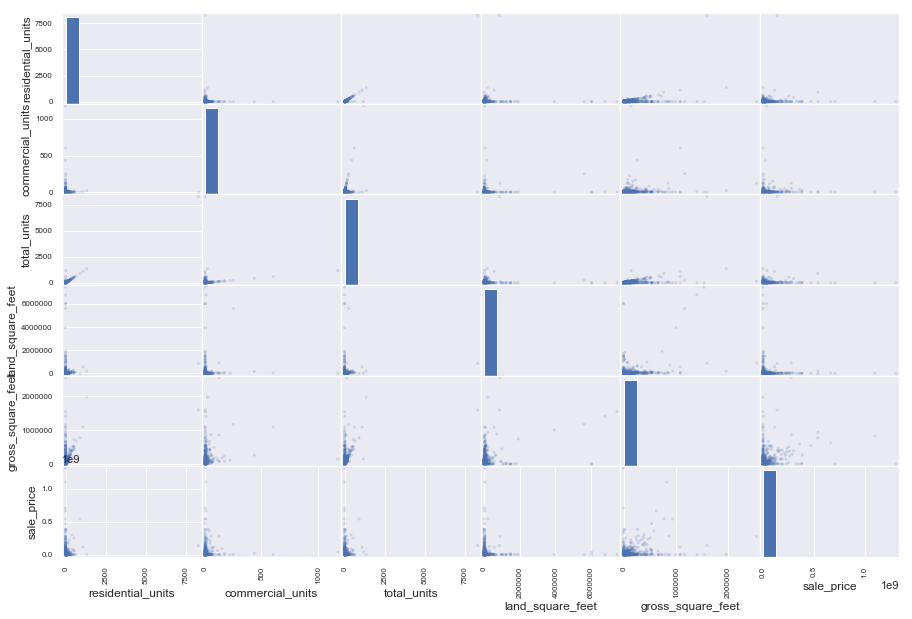

In [205]:
z = pd.plotting.scatter_matrix(data_outliers, alpha=0.2, figsize=(15, 10))

# at diagonal, all numerical features has outliers!

### sale_price
- missing or 0 values has to be eliminated. that's a sales data
- then, outliers eliminated

In [206]:
if (sale_price_min != -1):
    data_outliers = data_outliers[data_outliers.sale_price >= sale_price_min]


sale_price_min, len(data), len(data_outliers)

(1000, 85975, 56012)

In [207]:
q1 = data_outliers.sale_price.quantile(sale_price_lq)
q2 = data_outliers.sale_price.quantile(sale_price_rq)

data_outliers = data_outliers[(data_outliers.sale_price > q1) & (data_outliers.sale_price < q2)]

q1, q2, len(data), len(data_outliers)

(13047.0, 12000000.0, 85975, 54860)

In [208]:
if (sale_price_max != -1):
    data_outliers = data_outliers[data_outliers.sale_price <= sale_price_max]
    
sale_price_max, len(data), len(data_outliers)

(-1, 85975, 54860)

In [209]:
# check Zero values for transformation

data_outliers[data_outliers.sale_price == 0].head()[['sale_price']]

,sale_price


### land_square_feet, gross_square_feet
- missing or Zero values kept as is
- outliers eliminated

In [210]:
if (gross_square_feet_min != -1):
    data_outliers = data_outliers[(data_outliers.gross_square_feet > gross_square_feet_min)]
    
if (land_square_feet_min != -1):
    data_outliers = data_outliers[(data_outliers.land_square_feet > land_square_feet_min)]

land_square_feet_min, gross_square_feet_min, len(data), len(data_outliers)

(-1, -1, 85975, 54860)

In [211]:
q1 = data_outliers.gross_square_feet.quantile(gross_square_feet_lq)
q2 = data_outliers.gross_square_feet.quantile(gross_square_feet_rq)

data_outliers = data_outliers[(data_outliers.gross_square_feet > q1) & (data_outliers.gross_square_feet < q2)]

q1, q2, len(data), len(data_outliers)

(0.0, 112850.0, 85975, 23591)

In [212]:
q1 = data_outliers.land_square_feet.quantile(land_square_feet_lq)
q2 = data_outliers.land_square_feet.quantile(land_square_feet_rq)

data_outliers = data_outliers[(data_outliers.land_square_feet > q1) & (data_outliers.land_square_feet < q2)]

q1, q2, len(data), len(data_outliers)

(944.9, 18006.499999999935, 85975, 23119)

In [213]:
if (gross_square_feet_max != -1):
    data_outliers = data_outliers[(data_outliers.gross_square_feet < gross_square_feet_max)]
    
if (land_square_feet_max != -1):
    data_outliers = data_outliers[(data_outliers.land_square_feet < land_square_feet_max)]
    
land_square_feet_min, gross_square_feet_min, len(data), len(data_outliers)   

(-1, -1, 85975, 23119)

### residential_units, commercial_units, total_units
- total_units = residential_units + comercial_units

In [214]:
if (total_units_min != -1):
    data_outliers = data_outliers[(data_outliers.total_units > total_units_min)]


total_units_min, len(data), len(data_outliers) 

(0, 85975, 23064)

In [215]:
q1 = data_outliers.total_units.quantile(total_units_lq)
q2 = data_outliers.total_units.quantile(total_units_rq)

data_outliers = data_outliers[(data_outliers.total_units > q1) & (data_outliers.total_units < q2)]

q1, q2, len(data), len(data_outliers)

(1.0, 38.0, 85975, 13183)

In [216]:
if (total_units_max != -1):
    data_outliers = data_outliers[(data_outliers.total_units < total_units_max)]

total_units_max, len(data), len(data_outliers) 

(10, 85975, 12398)

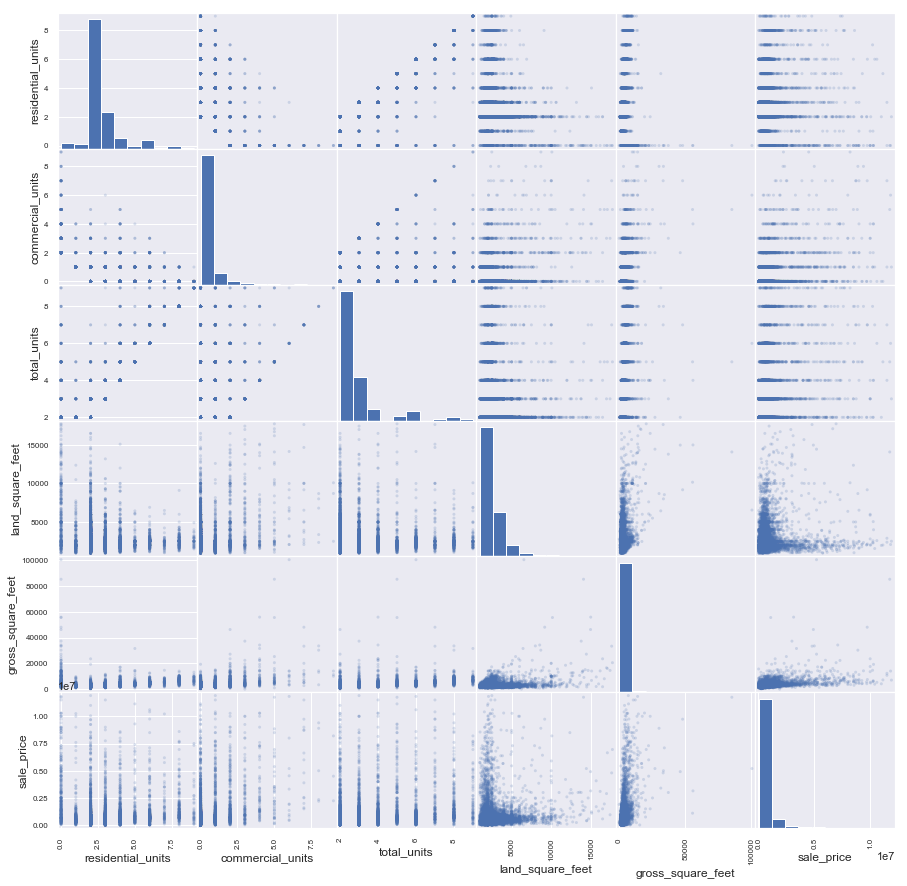

In [217]:
z = pd.plotting.scatter_matrix(data_outliers, alpha=0.2, figsize=(15, 15))

# at diagonal, all numerical features has outliers!

# Preprocessing for ML

In [218]:
data_prepared = data_outliers.copy()

In [219]:
# zeros problem in log transformation. so it is vital how to handle them in numerical features.

data_prepared['log_sale_price'] = np.log(data_prepared.sale_price)

data_prepared['log_gross_square_feet'] = np.log(data_prepared.gross_square_feet)
data_prepared['log_land_square_feet'] = np.log(data_prepared.land_square_feet)



In [220]:
data_prepared = data_prepared[['borough', 'neighborhood', 
                               'building_class', 'building_class_map', 
                               'building_category', 'building_category_map', 'building_type',
                               'tax_class', 'tax_class_map', 
                               'zipcode', 
                               'residential_units', 'commercial_units', 'total_units', 
                               'land_square_feet', 'log_land_square_feet', 'gross_square_feet', 'log_gross_square_feet', 'year_built', 'sale_date', 'sale_month',
                               'sale_year', 
                               'sale_price', 'log_sale_price']]

data_prepared.head(2)


,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,residential_units,commercial_units,total_units,land_square_feet,log_land_square_feet,gross_square_feet,log_gross_square_feet,year_built,sale_date,sale_month,sale_year,sale_price,log_sale_price
30,Brooklyn,BATH BEACH,S1,S,ONE FAMILY HOMES,FAMILY,COMMERCIAL W/ RESIDENTIAL,1,1,11214,1,1,2,2707,7.903596,3304,8.102889,1960,2012-11-29,11,2012,820000.0,13.617060
32,Brooklyn,BATH BEACH,S1,S,ONE FAMILY HOMES,FAMILY,COMMERCIAL W/ RESIDENTIAL,1,1,11214,1,1,2,1172,7.066467,1800,7.495542,1920,2013-06-03,6,2013,550000.0,13.217674


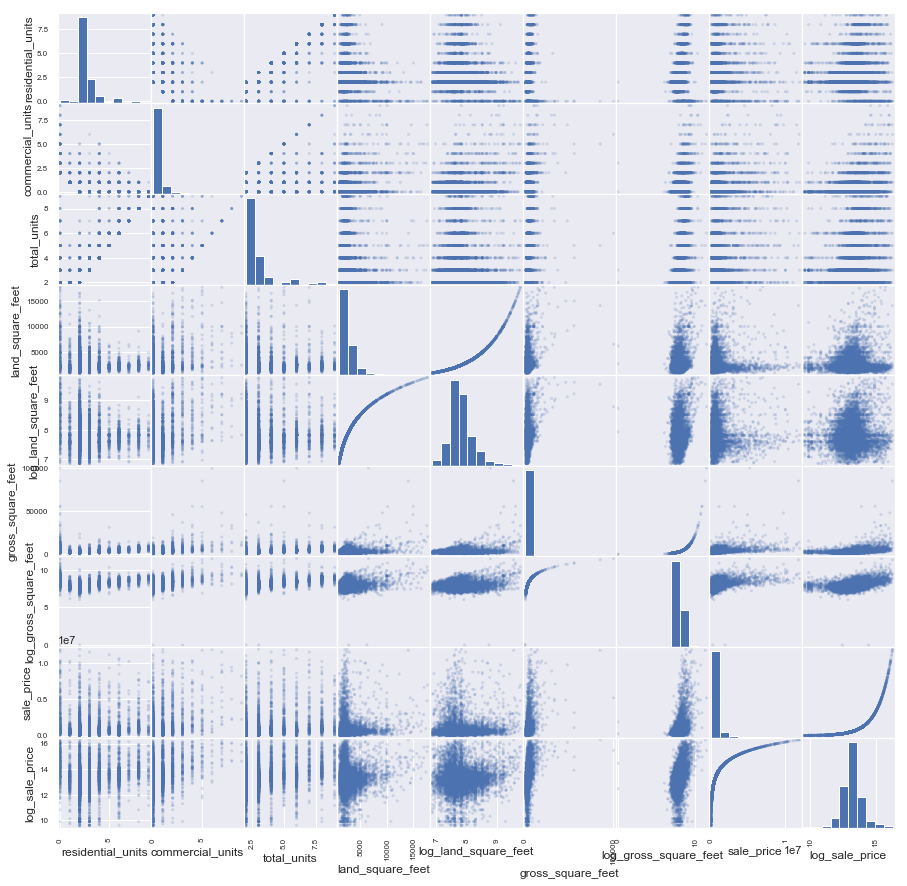

In [221]:
z = pd.plotting.scatter_matrix(data_prepared, alpha=0.2, figsize=(15, 15))

# at diagonal, all numerical features has outliers!
# after log transform, 
# - sale_price becomes normal distribution
# - land_square_feet (no outlier ops. done) becomes normal distribution. But gross_square_feet, has left skewed!